# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is practice of writing algorithms which can discover patterns in visual data. Such as the camera of self-driving car recognizing the car in front.

## Get the data

> We gonna use food101 dataset which consist of images of food.The images we're working with are from the Food101 dataset that includes 101 different classes of food. However we've modified it to only use two classes. (Pizza & steak).
Using the image data modification notebook:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

**Note:** We start with a small dataset so we can experiment quickly and figure what works.

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file.

zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2023-12-03 15:02:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   220MB/s    in 0.5s    

2023-12-03 15:02:45 (220 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data.

And for a computer vision project.. this usually means visualizing many samples of your data.

In [2]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")


There are 2 directories and 0 images in 'pizza_steak'. 
There are 2 directories and 0 images in 'pizza_steak/test'. 
There are 0 directories and 250 images in 'pizza_steak/test/pizza'. 
There are 0 directories and 250 images in 'pizza_steak/test/steak'. 
There are 2 directories and 0 images in 'pizza_steak/train'. 
There are 0 directories and 750 images in 'pizza_steak/train/pizza'. 
There are 0 directories and 750 images in 'pizza_steak/train/steak'. 


In [3]:
# Another find out how many images are there in file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_test = len(os.listdir("pizza_steak/test/steak"))
num_steak_images_train, num_steak_images_test

(750, 250)

> To visualize our images, first let's get the class names programmatically.

In [4]:
# Get the class names programatically
import pathlib
import numpy as np

data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['pizza', 'steak'], dtype='<U5')

In [5]:
# Let's visiualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random

def view_random(target_dir, target_class):
  # Set up the target directory (we'll view images from here)
  target_folder = target_dir + "/" + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print("random_image:", random_image)

  # Read in the image and plot it using matplotlibs
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print("image shape: ", img.shape) # width, height, color channels
  return tf.constant(img)

random_image: ['1888911.jpg']
image shape:  (512, 512, 3)


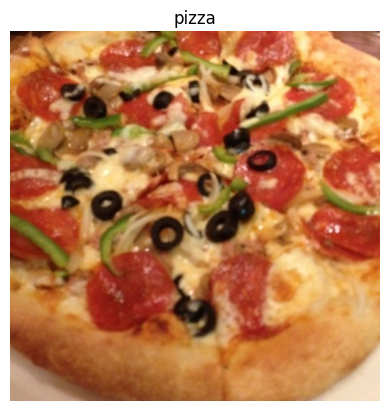

In [6]:
# View a random img from training dataset
img1 = view_random(target_dir="pizza_steak/train",target_class="pizza")

> As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common processing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255.(since 255 is maximum pixel value)

In [7]:
tf.math.reduce_max(img1)

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

In [8]:
# Get all the pixel values between 0 & 1
img1 / 255

<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
array([[[0.08235294, 0.02745098, 0.01568628],
        [0.08235294, 0.02745098, 0.01568628],
        [0.07843138, 0.03529412, 0.02745098],
        ...,
        [0.41960785, 0.2901961 , 0.22352941],
        [0.4       , 0.2784314 , 0.20784314],
        [0.40784314, 0.28627452, 0.21568628]],

       [[0.08235294, 0.02352941, 0.01176471],
        [0.08627451, 0.02745098, 0.01568628],
        [0.08627451, 0.03137255, 0.01960784],
        ...,
        [0.49411765, 0.3647059 , 0.29803923],
        [0.4745098 , 0.34509805, 0.2784314 ],
        [0.4862745 , 0.3647059 , 0.29411766]],

       [[0.09411765, 0.02352941, 0.00784314],
        [0.09411765, 0.02352941, 0.00784314],
        [0.09803922, 0.02745098, 0.01176471],
        ...,
        [0.6431373 , 0.5058824 , 0.43137255],
        [0.64705884, 0.50980395, 0.43529412],
        [0.6666667 , 0.5372549 , 0.4627451 ]],

       ...,

       [[0.7411765 , 0.60784316, 0.5019608 ],
        [0.73

## An end-to-end example

Let's build a convolutional neural networks to find patterns in our images, more specifically we a need to way to:

* Load our images
* Preprocessing our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set the seed
tf.random.set_seed(42)

# Preprocessing data (get all of the pixel values between 0 & 1, also called scale or normalization)
train_datagen = ImageDataGenerator(rescale=1./255) # Generate batches of tensor image data with real-time data augmentation.
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

# Import data from directories and turn into batches
# takes the path to a directory & generates batches of augmented data
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32, # its very common
                                               target_size=(244, 244), # its very common
                                               class_mode="binary", # we are working with 2 classes
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(244, 244),
                                               class_mode="binary",
                                               seed=42)


# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(244, 244, 3)),

    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

# Fit the model
model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 26s 179ms/step - loss: 0.5395 - accuracy: 0.7307 - val_loss: 0.3901 - val_accuracy: 0.8300
Epoch 2/5
47/47 [==============================] - 6s 136ms/step - loss: 0.4657 - accuracy: 0.7893 - val_loss: 0.4727 - val_accuracy: 0.7580
Epoch 3/5
47/47 [==============================] - 6s 130ms/step - loss: 0.4328 - accuracy: 0.8153 - val_loss: 0.4814 - val_accuracy: 0.7480
Epoch 4/5
47/47 [==============================] - 7s 151ms/step - loss: 0.4001 - accuracy: 0.8313 - val_loss: 0.3671 - val_accuracy: 0.8280
Epoch 5/5
47/47 [==============================] - 7s 151ms/step - loss: 0.3518 - accuracy: 0.8533 - val_loss: 0.4354 - val_accuracy: 0.8000


> Note: If the above cell is taking longer than 10s per epoch, make sure you're using a GPU by going to Runtime -> Hardware Acceleator -> GPU (you may have to rerun some cells above)

In [10]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 120, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 116, 116, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 10)        0         
 g2D)                                                   

## Using the same modelas before

> Let's replicate the model we've built in a previous section to see if it works with our image data.

In [11]:
# Set random seed
tf.random.set_seed(42)

# 1.Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(244, 244, 3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2.Compile the model
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 3.Fit the model
model_2.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
            validation_data = valid_data, validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 7s 117ms/step - loss: 1.1831 - accuracy: 0.4827 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 6s 138ms/step - loss: 0.6932 - accuracy: 0.4813 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 212ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 114ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 6s 139ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5000


In [12]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 178608)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 714436    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 714461 (2.73 MB)
Trainable params: 714461 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Despite having 20x more parameters than our CNN(model_1), model_2 performs terribly...

In [13]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(244, 244, 3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_3 = model_3.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
            validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 7s 117ms/step - loss: 3.5281 - accuracy: 0.6013 - val_loss: 0.5614 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 6s 125ms/step - loss: 0.6820 - accuracy: 0.7067 - val_loss: 0.5351 - val_accuracy: 0.7340
Epoch 3/5
47/47 [==============================] - 7s 143ms/step - loss: 0.5666 - accuracy: 0.7407 - val_loss: 0.5090 - val_accuracy: 0.7580
Epoch 4/5
47/47 [==============================] - 6s 121ms/step - loss: 0.5977 - accuracy: 0.7467 - val_loss: 0.4812 - val_accuracy: 0.7720
Epoch 5/5
47/47 [==============================] - 6s 127ms/step - loss: 0.6238 - accuracy: 0.7387 - val_loss: 0.5464 - val_accuracy: 0.7720


In [14]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 178608)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               17860900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 17881201 (68.21 MB)
Trainable params: 17881201 (68.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> CNN model was better than neural networks despite neural networks has more 500 times paramaters than CNN

> You can think of trainable parameters as **patterns a model can learn from data**. Intutively, you might think more is better. And it lots of case it is. But in this case, the difference here is the two different styles we're using. Where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important pattern in an image**. So even though these are less learnable parameters in our convolutional neural networks, these are often more helpful in dechiphering between different features in an image.

# Binary Classification! Let's break it down..

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepared it for our model, the main step here was scaling/normalizing & turning our data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat untill satisfied.

## 1. Become one with the data

random_image: ['389739.jpg']
image shape:  (384, 512, 3)
random_image: ['527199.jpg']
image shape:  (512, 512, 3)


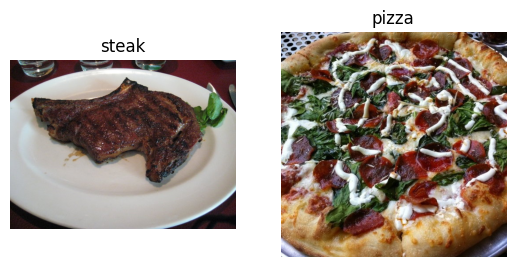

In [15]:
# Visualize the data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random(target_dir="/content/pizza_steak/train", target_class="steak")
plt.subplot(1,2,2)
pizza_img = view_random(target_dir="/content/pizza_steak/train", target_class="pizza")

## 2. Preprocess the data

- Turn all data into numbers (Neural networks cannot handle with images)
- Make sure all of your tensors are the right shape
- Scale features (normalize or standardize, neural networks tend to prefer normalization)

In [16]:
# Define directory dataset paths
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

> Our next step is to turn our data into **batches**.

- A batch is small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

> It does this for a couple of reasons:
1. 10.000 images (or more) might not fit into the memory of your processor(GPU)
2. Trying to learn the patterns in 10.000 images in one hit could result in the model not being able to learn very well.

> Wtf is 32 ?
- Because 32 is good for your health..

In [17]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generate bathes of tensor image data with real-time data augmentation.
train_datagen = ImageDataGenerator(rescale=1/255.) # Get the all pixel values between 0 & 1
test_datagen = ImageDataGenerator(rescale=1/255.) # Get the all pixel values between 0 & 1


In [18]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # Target directory of images
                                               target_size=(224, 224), # Target size of images (height, width)
                                               class_mode="binary", # type of data you're working with
                                               batch_size=32) # size of minibatches to load data into

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [19]:
# Get a sample of a train data batch

images, labels = train_data.next() # get the "next" batch of images/labels in train_data
len(images), len(labels) # batches = 32

(32, 32)

In [20]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [21]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

## 3. Create a CNN Model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experiment and then as you keep experimenting, you try to beat the baseline.

**Note:** In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required. (e.g. look at which current model is performing best in the field for your problem.)

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

# Create a model

model_4 = Sequential([
    Conv2D(filters=10, # Decides how many filters should pass over an input tensor (e.g. sliding windows over an image.) Higher values lead to more complex models
           kernel_size=3, # 3 = (3, 3) -> Determines the shape of the filters (sliding windows) over the output. lower values learn small features, higher values learn larger features.
           strides=1, # 1 = (1, 1) ->  The number of steps a filter takes across an image at a time. (e.g. if strides=1, a filter moves across an image 1 pixel at a time.)

           padding="valid", # Pads the target tensor with zeros(if "same") to preserve input shape. Or leaves in the target tensor as is (if "valid"), lowering output shape.
           # If you want to hold more information in your input tensor, you'd leave it as same.
           # if "same" output shape is same as input shape. if "valid" output shape gets compressed.

           activation="relu",
           input_shape = (224,224, 3)), # input layer

    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid") # output layer
])

In [23]:
# Compile the model
model_4.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)



> if we use padding="same", output shape of the first layer will be 224, 224, 10.

In [24]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4. Fit the model


In [25]:
# Check the lengths of training and test data generators

print(f"we've got {len(train_data)} batches of training data")
print(f"we've got {len(test_data)} batches of test data")

we've got 47 batches of training data
we've got 16 batches of test data


In [26]:
# Fit the model

history_4 = model_4.fit(train_data, # this is a combination of labels and sample data. so we don't need to pass X and Y
                        epochs=5,
                        steps_per_epoch=len(train_data), # this is telling to flow to step through the train data or each epoch take 47 steps.
                        validation_data=test_data,
                        validation_steps=len(test_data)
                        )


Epoch 1/5
47/47 [==============================] - 10s 155ms/step - loss: 1.0397 - accuracy: 0.6533 - val_loss: 0.5561 - val_accuracy: 0.7280
Epoch 2/5
47/47 [==============================] - 7s 147ms/step - loss: 0.4943 - accuracy: 0.7700 - val_loss: 0.4159 - val_accuracy: 0.8080
Epoch 3/5
47/47 [==============================] - 6s 119ms/step - loss: 0.3466 - accuracy: 0.8587 - val_loss: 0.4239 - val_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 6s 121ms/step - loss: 0.2219 - accuracy: 0.9240 - val_loss: 0.4015 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 6s 133ms/step - loss: 0.0936 - accuracy: 0.9720 - val_loss: 0.5261 - val_accuracy: 0.8100


In [27]:
model_1.evaluate(valid_data)

16/16 [==============================] - 2s 92ms/step - loss: 0.4354 - accuracy: 0.8000


[0.43535473942756653, 0.800000011920929]

In [28]:
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 120, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 116, 116, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 10)        0         
 g2D)                                                   

In [29]:
model_4.evaluate(test_data)

16/16 [==============================] - 1s 83ms/step - loss: 0.5261 - accuracy: 0.8100


[0.5260574221611023, 0.8100000023841858]

In [30]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> accuracy of model_4 is lower than model_1 but model_1 has a lot of layers as you see summary of model_1. Despite model_4 does not have any max pooling layer, accuracy is close to model_1.

## 5. Evaluating our model

It looks like our model is learning something. Let's evaluate it

<Axes: >

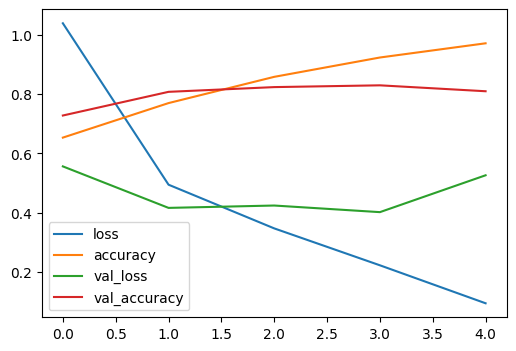

In [31]:
import pandas as pd

pd.DataFrame(history_4.history).plot(figsize=(6,4))

In [32]:
# Plot the validation and traing curves seperately
def plot_loss_curves(history):
  """
  returns seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, acc, label="training accuracy")
  plt.plot(epochs, val_acc, label="validation accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()

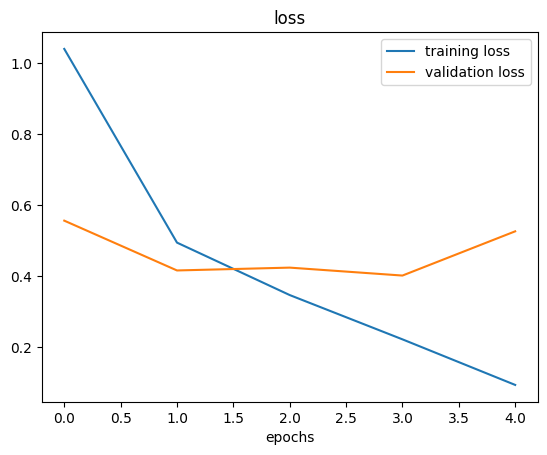

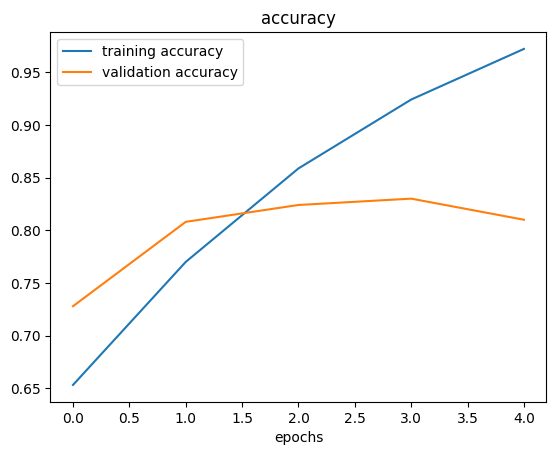

In [33]:
plot_loss_curves(history_4)

> **Note:** When a model's **validation loss starts to increase**, it's likely that model is **overfitting** the training dataset.

This means, it's learning the patterns in training dataset **too_well** and thus the model's ability to generalize to unseen data will be diminished.

## 6. Adjust the model parameters
Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:

* Increase the number of conv layer
* Increase the number of conv filter
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data..


**Note:** Reducing overfitting known as ***regularization***.

In [34]:
# Create the model
model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2), # It finds most important parts in the features (pixels). we give (2x2) matrix and it returns (1x1) matrix. It finds the biggest value inside the matrix
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])


In [35]:
# Compile the model
model_5.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [36]:
# Fit the model
history_5 = model_5.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
                        validation_data=test_data, validation_steps=len(valid_data)
                        )

Epoch 1/5
47/47 [==============================] - 9s 145ms/step - loss: 0.6034 - accuracy: 0.6747 - val_loss: 0.4662 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 7s 141ms/step - loss: 0.4616 - accuracy: 0.8007 - val_loss: 0.3614 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 5s 114ms/step - loss: 0.4211 - accuracy: 0.8087 - val_loss: 0.3678 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 6s 126ms/step - loss: 0.3925 - accuracy: 0.8300 - val_loss: 0.3313 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 5s 111ms/step - loss: 0.3730 - accuracy: 0.8387 - val_loss: 0.3190 - val_accuracy: 0.8680


In [37]:
model_5.evaluate(test_data)

16/16 [==============================] - 3s 138ms/step - loss: 0.3190 - accuracy: 0.8680


[0.31902259588241577, 0.8679999709129333]

In [38]:
model_4.evaluate(test_data)

16/16 [==============================] - 3s 196ms/step - loss: 0.5261 - accuracy: 0.8100


[0.5260573029518127, 0.8100000023841858]

In [39]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

In [40]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> Despite model_4 has 50 times more total params than model_5, accuracy of model_5 is higher than model_4

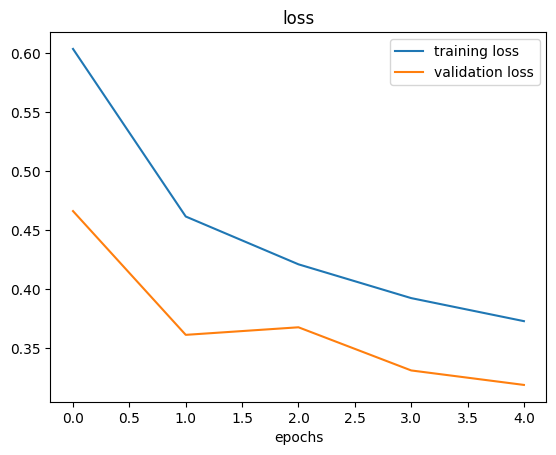

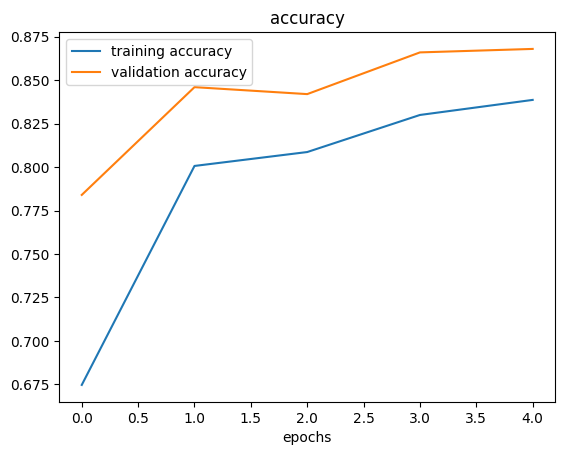

In [41]:
plot_loss_curves(history_5)

> By MaxPooling, model has the best chance to learn the most important features.

## Opening our bag of tricks and finding data augmentation

In [42]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True
                                             )

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)


> What is data augmentation?
- Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Let's write some code to visualize data augmentation..


In [43]:
train_datagen_augmented